In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
def loadseq(file):
    lines = []
    with open(file, 'r') as file:
        for line in file:
            lines.append(line.strip())
    return lines


glutfile = 'glutoutputnoheader.fasta'
sgltfile = 'newsgltoutputnoheader.fasta'
sweetfile = 'newsweetoutputnoheader.fasta'
# hxtfile = 'hxtoutputnoheader.fasta'
# chbfile = 'chboutputnoheader.fasta'


glut = loadseq(glutfile)
sglt = loadseq(sgltfile)
sweet = loadseq(sweetfile)
# hxt = loadseq(hxtfile)
# chb = loadseq(chbfile)

# glut = glut[:25]
# hxt = hxt[:25]
# chb = chb[:5]

glutlen = len(glut)
sgltlen = len(sglt)
sweetlen = len(sweet)
# hxtlen = len(hxt)
# chblen = len(chb)

len(glut),len(sglt),len(sweet)

(396, 24, 675)

In [3]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # List of amino acids
n_amino_acids = len(amino_acids)  # Number of amino acids

In [4]:
def calculate_aac_features(sequences, amino_acids):
    n_amino_acids = len(amino_acids)
    features = []
    for fasta_sequence in sequences:
        aac = np.zeros(n_amino_acids)
        for aa in fasta_sequence:
            if aa in amino_acids:
                index = amino_acids.index(aa)
                aac[index] += 1

        # Normalize the amino acid composition to obtain relative frequencies
        aac /= len(fasta_sequence)

        # Append the AAC feature vector to the feature list
        features.append(aac)

    return np.array(features)

In [5]:
glut_ = calculate_aac_features(glut,amino_acids)
sglt_ = calculate_aac_features(sglt,amino_acids)
sweet_ = calculate_aac_features(sweet,amino_acids)
# hxt_ = calculate_aac_features(hxt,amino_acids)
# chb_ = calculate_aac_features(chb,amino_acids)

In [12]:
glut_test_count = 47
sglt_test_count = 6
sweet_test_count = 47

x_train = np.concatenate((glut_[:glutlen-glut_test_count], sglt_[:sgltlen-sglt_test_count], sweet_[:sweetlen-sweet_test_count]), axis=0)
x_test = np.concatenate((glut_[glutlen-glut_test_count:], sglt_[sgltlen-sglt_test_count:], sweet_[sweetlen-sweet_test_count:]), axis=0)

# x_train = np.concatenate((glut_[:glutlen-1], sglt_[:sgltlen-1], hxt_[:hxtlen-1], chb_[:chblen-1]), axis=0)
# x_test = np.concatenate((glut_[glutlen-1:], sglt_[sgltlen-1:], hxt_[hxtlen-1:], chb_[chblen-1:]), axis=0)

# Create the corresponding labels

y_train = np.array(["GLUT"] * (glutlen-glut_test_count) + ["SGLT"] * (sgltlen-sglt_test_count) + ["SWEET"] * (sweetlen-sweet_test_count))
y_test = np.array(["GLUT"] * glut_test_count + ["SGLT"] * sglt_test_count + ["SWEET"] * sweet_test_count)

# y_train = np.array(["GLUT"] * (glutlen-1) + ["SGLT"] * (sgltlen-1) + ["HXT"] * (hxtlen-1) + ["CHB"] * (chblen-1))
# y_test = np.array(["GLUT"] * 1 + ["SGLT"] * 1 + ["HXT"] * 1 + ["CHB"] * 1)

x_train.shape

(995, 20)

In [13]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

y_pred_train = classifier.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test, y_pred_test

Training Accuracy: 0.9979899497487437
Testing Accuracy: 0.79


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['SWEET', 'SWEET', 

In [14]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test, y_pred_test

Training Accuracy: 0.8904522613065327
Testing Accuracy: 0.77


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['SWEET', 'SWEET', 

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train, y_train)

y_pred_train = knn.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = knn.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test, y_pred_test

Training Accuracy: 0.9125628140703518
Testing Accuracy: 0.84


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['GLUT', 'GLUT', 'G

In [28]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train))
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test = encoder.inverse_transform(y_test)
y_pred_test = encoder.inverse_transform(y_pred_test)
y_test, y_pred_test


Training Accuracy: 0.9979899497487437
Testing Accuracy: 0.86


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)
y_test_enc = le.transform(y_test)
print(y_test_enc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.metrics  import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
tpr,fpr, threshold = roc_curve(y_test,y_pred_test)

roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Combined ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

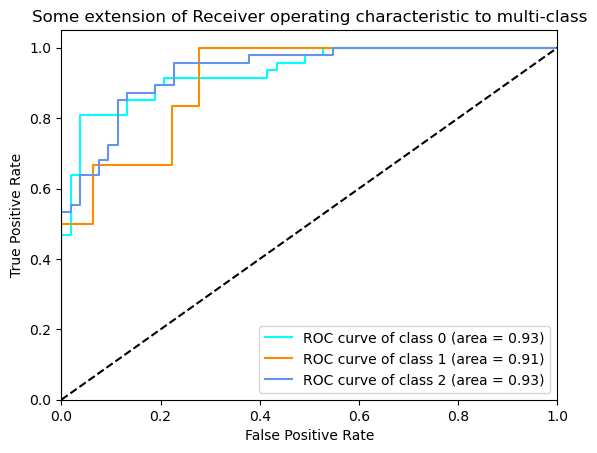

In [24]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_train))) # number of classes should be number of unique labels
model.fit(x_train, y_train)

y_score = model.predict_proba(x_test)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
